In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator


## For biased reweighting

In [2]:
# reweighting:
def exp_beta_Vbias(s, nline, hbias, sbias, wbias, beta):
    """
    exp(beta*Vbias)
    Number of hbias and sbias should less than or equal to nline.
    """
    if nline<len(hbias) or nline<len(sbias):
        raise TypeError
    
    Vbias = np.sum(hbias*np.exp(-0.5*(s-sbias)**2/wbias**2))
    return np.exp(beta*Vbias)

def exp_beta_c(nline, hbias, sbias, wbias, beta, delta_beta):
    """
    exp(beta*c[nline]) # nline is t in unit of lines.
    Number of hbias and sbias should less than or equal to nline.
    """
    # if the following statement is not true, the causality breaks.
    if nline<len(hbias) or nline<len(sbias):
        raise ValueError
    # nline=0 is the initial configuration. Without this line, the following sb_max/sb_min break.
    if nline==0: 
        return 1
    
    T, dT = 1/beta, 1/delta_beta
    exp_num, exp_den = (T+dT)/dT, T/dT
    
    ds=0.02 # integration interval
    sb_max=np.max(sbias)+5*ds
    sb_min=np.min(sbias)-5*ds

    num=np.sum([exp_beta_Vbias(ss, nline, hbias, sbias, wbias, beta)**exp_num for ss in np.arange(sb_min, sb_max, ds)])
    den=np.sum([exp_beta_Vbias(ss, nline, hbias, sbias, wbias, beta)**exp_den for ss in np.arange(sb_min, sb_max, ds)])
    
    return num/den
    

## Spectral gap and Maxcal-based transition matrix

In [3]:
def stationary(rc, rc_bin, weights=None):
    """
    build stationary probability distribution.
    """
    if weights is None:
        hist=np.histogram(rc, bins=rc_bin)
        prob=hist[0].T/np.sum(hist[0].T)
    else:
        hist=np.histogram(rc, weights=weights, bins=rc_bin)
        prob=hist[0].T/np.sum(hist[0].T)
    
    return prob
    
def mu_factor(unbiased_rc, pi, rc_bin, max_d=1):
    """
    The dynamical prefactor in maxcal estimated transition rate matrix. 
    This was related to the constraints of the number of first nearest neighbor transitions.
    """
    rc_min, rc_max=np.min(unbiased_rc), np.max(unbiased_rc)
    bins=np.linspace(rc_min, rc_max, rc_bin+1)
    unbiased_rc_idx=np.digitize(unbiased_rc, bins)
    
    d=np.arange(max_d)+1
    MU=np.zeros(max_d)
    for i, di in enumerate(d):
        D=np.sum(np.sqrt(pi[:-di]*pi[di:]))
        N_mean=np.sum(np.abs(unbiased_rc_idx[:-di]-unbiased_rc_idx[di:])==1)
        N_mean/=len(unbiased_rc_idx)
        MU[i]=N_mean/D
        
    return MU
    
def sg_transmat(rc_bin, pi, MU, max_d=1):
    """
    Build the SGOOP transition rate matrix. Attention: max_d>1 may result in less accuracy due to poor sampling of 
    higher-order neighbor transitions.
    """
    d=np.arange(max_d)+1
    S=np.zeros((rc_bin, rc_bin))
    for i, di in enumerate(d):
        j=np.arange(rc_bin-di)
        k=j+di
        
        S[j,k] = MU[i]*np.sqrt(np.ma.divide(pi[j], pi[k]))
        S[k,j] = MU[i]*np.sqrt(np.ma.divide(pi[k], pi[j]))
    
    S[np.diag_indices(rc_bin)] = -np.sum(S, axis=0) # Diagonal terms
    
    return S
    
def eigenval(sg_transmat):
    """
    Compute eigenvalues and eigenvectors.
    """
    eigenValues, eigenVectors = np.linalg.eig(sg_transmat)
    idx = eigenValues.argsort()[::-1]     # Sorting by eigenvalues
    eigenValues = eigenValues[idx]        # Order eigenvalues
    eigenVectors = eigenVectors[:,idx]    # Order eigenvectors
    eigenExp = np.exp(eigenValues)        # Calculate exponentials
    
    return eigenValues, eigenExp, eigenVectors
    
def sgap(sg_transmat, wells):
    """
    Calculate the spectral gap with self-consistent number of potential wells along the reaction coordinate.
    """
    E = eigenval(sg_transmat)
    
    return E[1][wells-1]-E[1][wells]


In [4]:
# data:
filename={}
x={}
y={}
hbias={} 
xbias={} 
ybias={}

# MD parameters:
beta=2.5
Rout=100  # (unit: steps/lines)

# metaD parameters:
stride={}
wbias={}
delta_beta={}

# SGOOP parameters:
rc_bin={}
wells={}
th={}
coeff={}
rc={}
pi={}
MU={}
S={}
E={}


In [5]:
# Read unbiased data:
filename['unbiased']='./DATA/unbiased/beta2.5/xvyw1beta2.5gammax1.0gammay1.0epsln1.0sgma1.0A2.5x01.122w0.8B1.0a1.0_h0.01.txt'
x['unbiased'], y['unbiased'] = np.loadtxt(filename['unbiased'], unpack=True, usecols=(0,1), skiprows=1, max_rows=10000)

# Read biased data:
filename['biased_1']='./DATA/h0_4_w0_2_db0_01_stride200_cx0_891_cy0_454/xvyw1beta2.5gammax1.0gammay1.0epsln1.0sgma1.0A2.5x01.122w0.8B1.0a1.0_h0.01.txt'
x['1'], y['1'], hbias['1'], xbias['1'], ybias['1'] = np.loadtxt(filename['biased_1'], unpack=True, usecols=(0,1, 6,7,8), skiprows=1)


coeff0: trial rc
<br>
coeff1: first rc determined by SGOOP
<br>
coeff2: second rc determined by SGOOP

In [17]:
# parameters:
coeff['0'] = np.array([0.891, 0.454])
stride['1']=200
stride['1'] = stride['1']//Rout # (unit: lines), stride = 1000 steps
wbias['1']=0.2
delta_beta['1']=0.01

# data:
s=coeff['0'][0]*x['1']+coeff['0'][1]*y['1']
sbias=coeff['0'][0]*xbias['1']+coeff['0'][1]*ybias['1']

weights=np.zeros(s.shape[0])
for i, si in enumerate(s):
    sbias_t=sbias[:i:stride['1']]
    hbias_t=hbias['1'][:i:stride['1']]
    weights[i]=exp_beta_Vbias(si, i, hbias_t, sbias_t, wbias['1'], beta)/exp_beta_c(i, hbias_t, sbias_t, wbias['1'], beta, delta_beta['1'])
    

In [31]:
np.savetxt('weights.txt', weights)

In [6]:
weights=np.loadtxt('weights.txt')

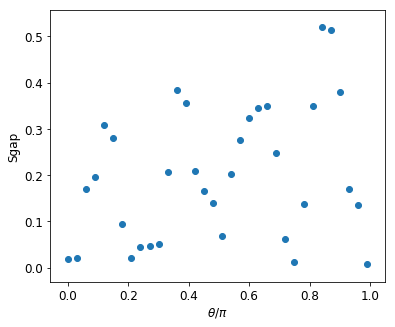

Maximal sgap at 
th=0.84pi
  =151.2(degrees)


In [7]:
# parameters:
rc_bin['1']=20
wells['1']=4
num_pt=34
rc_interval=0.03
coeff['i']=np.zeros(2)

# data:
sgap_arr=np.zeros(num_pt)
i_arr=np.arange(num_pt)
for i in i_arr:
    th['i'] = np.pi*i*rc_interval
    coeff['i'][0], coeff['i'][1] = np.cos(th['i']), np.sin(th['i'])
    rc['unbiased'] = coeff['i'][0]*x['unbiased'] + coeff['i'][1]*y['unbiased']
    rc['i'] = coeff['i'][0]*x['1'] + coeff['i'][1]*y['1']
    
    pi['i'] = stationary(rc['i'], rc_bin=rc_bin['1'], weights=weights)
    MU['i'] = mu_factor(rc['unbiased'], pi['i'], rc_bin=rc_bin['1'], max_d=1)
    S['i'] = sg_transmat(rc_bin['1'], pi['i'], MU['i'], max_d=1)
    sgap_arr[i] = sgap(S['i'], wells['1'])
    
# Plottings:
fig, ax=plt.subplots(figsize=(6,5))
ax.scatter(rc_interval*i_arr, sgap_arr)
ax.tick_params(which='major', axis='both', labelsize=12)
ax.set_xlabel('$\\theta/\pi$', size=12)
ax.set_ylabel('Sgap', size=12)

plt.show()

print('Maximal sgap at \nth={}pi\n  ={}(degrees)'.format(rc_interval*np.argmax(sgap_arr), rc_interval*np.argmax(sgap_arr)*180))


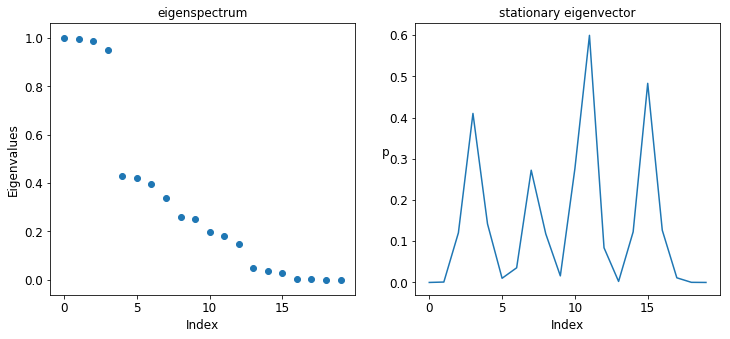

In [8]:
# parameters:
rc_bin['1']=20
th['1']=0.84*np.pi
coeff['1']=np.zeros(2)
coeff['1'][0], coeff['1'][1] = np.cos(th['1']), np.sin(th['1'])

# data:
rc['unbiased'] = coeff['1'][0]*x['unbiased'] + coeff['1'][1]*y['unbiased']
rc['1'] = coeff['1'][0]*x['1'] + coeff['1'][1]*y['1']
pi['1'] = stationary(rc['1'], rc_bin=rc_bin['1'], weights=weights)
MU['1'] = mu_factor(rc['unbiased'], pi['1'], rc_bin=rc_bin['1'], max_d=1)
S['1'] = sg_transmat(rc_bin['1'], pi['1'], MU['1'], max_d=1)
E['1'] = eigenval(S['1']) # E[1]=eigenvals, exp_eigenvals, eigenvectors

# Plottings:
fig, ax=plt.subplots(figsize=(12,5), nrows=1, ncols=2)

ax[0].scatter(list(range(len(E['1'][1]))), E['1'][1])
ax[1].plot(np.abs(E['1'][2][:,0]))

ax[0].set_title('eigenspectrum', size=12)
ax[0].tick_params(which='major', axis='both', labelsize=12)
ax[0].set_xlabel('Index', size=12)
ax[0].set_ylabel('Eigenvalues', size=12)

ax[1].set_title('stationary eigenvector')
ax[1].tick_params(which='major', axis='both', labelsize=12)
ax[1].set_xlabel('Index', size=12)
ax[1].set_ylabel('p', size=12).set_rotation(0)

plt.show()


# Second SGOOP

In [9]:
coeff['1']

array([-0.87630668,  0.48175367])

In [10]:
# Read biased data:
filename['biased_2']='./DATA/h0_4_w0_2_db0_01_stride200_cxm0_876_cy0_482/xvyw1beta2.5gammax1.0gammay1.0epsln1.0sgma1.0A2.5x01.122w0.8B1.0a1.0_h0.01.txt'
x['2'], y['2'], hbias['2'], xbias['2'], ybias['2'] = np.loadtxt(filename['biased_2'], unpack=True, usecols=(0,1, 6,7,8), skiprows=1)


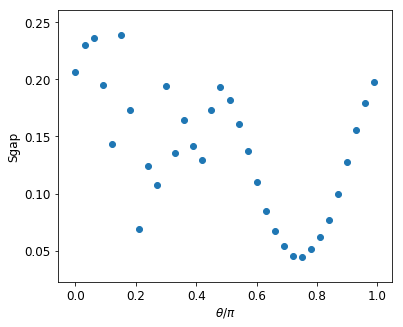

Maximal sgap at 
th=0.15pi
  =27.0(degrees)


In [11]:
# parameters:
rc_bin['2']=20
wells['2']=4
num_pt=34
rc_interval=0.03
coeff['i']=np.zeros(2)

# data:
sgap_arr=np.zeros(num_pt)
i_arr=np.arange(num_pt)
for i in i_arr:
    th['i'] = np.pi*i*rc_interval
    coeff['i'][0], coeff['i'][1] = np.cos(th['i']), np.sin(th['i'])
    rc['i'] = coeff['i'][0]*x['2'] + coeff['i'][1]*y['2']
    
    pi['i'] = stationary(rc['i'], rc_bin=rc_bin['2'])
    MU['i'] = mu_factor(rc['i'], pi['i'], rc_bin=rc_bin['2'], max_d=1)
    S['i'] = sg_transmat(rc_bin['2'], pi['i'], MU['i'], max_d=1)
    sgap_arr[i] = sgap(S['i'], wells['2'])
    
# Plottings:
fig, ax=plt.subplots(figsize=(6,5))
ax.scatter(rc_interval*i_arr, sgap_arr)
ax.tick_params(which='major', axis='both', labelsize=12)
ax.set_xlabel('$\\theta/\pi$', size=12)
ax.set_ylabel('Sgap', size=12)

plt.show()

print('Maximal sgap at \nth={}pi\n  ={}(degrees)'.format(rc_interval*np.argmax(sgap_arr), rc_interval*np.argmax(sgap_arr)*180))


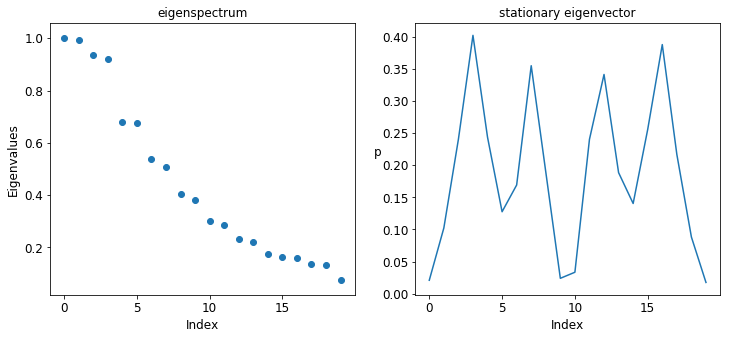

In [12]:
# parameters:
rc_bin['2']=20
th['2']=0.15*np.pi
coeff['2']=np.zeros(2)
coeff['2'][0], coeff['2'][1] = np.cos(th['2']), np.sin(th['2'])

# data:
rc['2'] = coeff['2'][0]*x['2'] + coeff['2'][1]*y['2']
pi['2'] = stationary(rc['2'], rc_bin=rc_bin['2'])
MU['2'] = mu_factor(rc['2'], pi['2'], rc_bin=rc_bin['2'], max_d=1)
S['2'] = sg_transmat(rc_bin['2'], pi['2'], MU['2'], max_d=1)
E['2'] = eigenval(S['2'])

# Plottings:
fig, ax=plt.subplots(figsize=(12,5), nrows=1, ncols=2)

ax[0].scatter(list(range(len(E['2'][1]))), E['2'][1])
ax[1].plot(np.abs(E['2'][2][:,0]))

ax[0].set_title('eigenspectrum', size=12)
ax[0].tick_params(which='major', axis='both', labelsize=12)
ax[0].set_xlabel('Index', size=12)
ax[0].set_ylabel('Eigenvalues', size=12)

ax[1].set_title('stationary eigenvector')
ax[1].tick_params(which='major', axis='both', labelsize=12)
ax[1].set_xlabel('Index', size=12)
ax[1].set_ylabel('p', size=12).set_rotation(0)

plt.show()


## RC1 and RC2

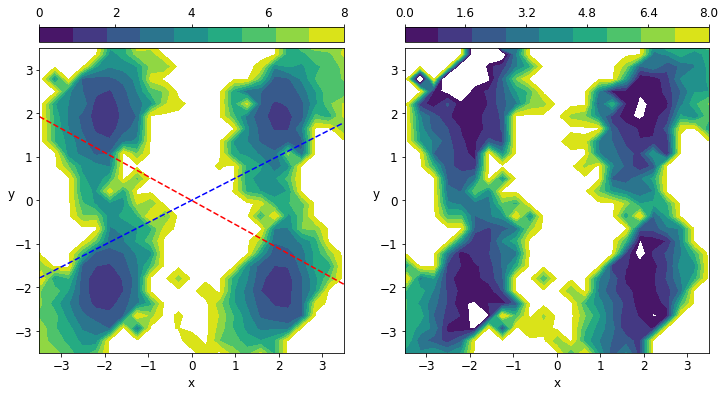

In [13]:
# parameters:
levels=np.linspace(0.0, 8.0, 10)

# data:
rw_hist2d=np.histogram2d(x['1'], y['1'], weights=weights, bins=50)
rw_prob2d=rw_hist2d[0].T/np.sum(rw_hist2d[0])
rw_freeE2d=(-1/beta)*np.log(rw_prob2d+1e-9)
rw_x2d=0.5*(rw_hist2d[1][1:]+rw_hist2d[1][:-1])
rw_y2d=0.5*(rw_hist2d[2][1:]+rw_hist2d[2][:-1])

rw_hist1d=np.histogram(coeff['1'][0]*x['1']+coeff['1'][1]*y['1'], weights=weights, bins=rc_bin['1'])
rw_prob1d=rw_hist1d[0].T/np.sum(rw_hist1d[0])

rw_hist1d[1][-1]+=100 # Add 100 to ensure that the right edge is inclusive.
for i, xi in enumerate(rw_x2d):
    for j, yj in enumerate(rw_y2d):
        k=np.digitize(coeff['1'][0]*xi+coeff['1'][1]*yj, rw_hist1d[1])-1
        rw_prob2d[i,j]/=(rw_prob1d[k]+1e-9) # divide the reweighted prob by 1d prob along RC.

rw_freeE2d_2com=(-1/beta)*np.log(rw_prob2d+1e-9) # reweighted 2d free energy for 2nd component RC.

rc_x=np.linspace(-3.5, 3.5)
rc1_y=np.tan(th['1'])*rc_x
rc2_y=np.tan(th['2'])*rc_x

# Plottings:
fig, ax=plt.subplots(figsize=(12,6), nrows=1, ncols=2)

ctrp = ax[0].contourf(rw_x2d, rw_y2d, rw_freeE2d, levels=levels)

ax[0].plot(rc_x, rc1_y, 'r--')
ax[0].plot(rc_x, rc2_y, 'b--')

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('top', size='5%', pad='2%')
ticks=np.round(np.linspace(-2.0, 8.0 , 6), 1)
cbr = fig.colorbar(ctrp, cax=cax, ticks=ticks, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cbr.ax.tick_params(labelsize=12)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_xlabel('x', size=12)
ax[0].set_ylabel('y', size=12).set_rotation(0)
ax[0].set_xlim(-3.5, 3.5)
ax[0].set_ylim(-3.5, 3.5)

ctrp = ax[1].contourf(rw_x2d, rw_y2d, rw_freeE2d_2com, levels=levels)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('top', size='5%', pad='2%')
ticks=np.round(np.linspace(0.0, 8.0 , 6), 1)
cbr = fig.colorbar(ctrp, cax=cax, ticks=ticks, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cbr.ax.tick_params(labelsize=12)

ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel('x', size=12)
ax[1].set_ylabel('y', size=12).set_rotation(0)
ax[1].set_xlim(-3.5, 3.5)
ax[1].set_ylim(-3.5, 3.5)

plt.show()

# Commute map

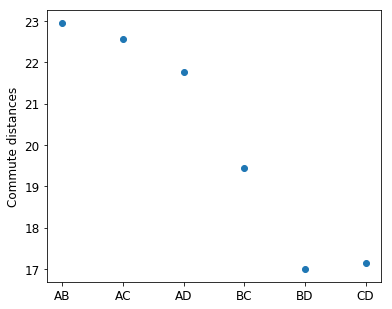

In [17]:
def commutemap2d(pos1, pos2):
    
    _, binedges1=np.histogram(coeff['1'][0]*x['1']+coeff['1'][1]*y['1'], bins=rc_bin['1'])
    binedges1[-1]+=1000 # Add 100 to ensure that the right edge is inclusive.
    
    i1=np.digitize(coeff['1'][0]*pos1[0]+coeff['1'][1]*pos1[1], binedges1)-1
    j1=np.digitize(coeff['1'][0]*pos2[0]+coeff['1'][1]*pos2[1], binedges1)-1
    
    _, binedges2=np.histogram(coeff['2'][0]*x['2']+coeff['2'][1]*y['2'], bins=rc_bin['2'])
    binedges2[-1]+=1000 # Add 100 to ensure that the right edge is inclusive.
    
    i2=np.digitize(coeff['2'][0]*pos1[0]+coeff['2'][1]*pos1[1], binedges2)-1
    j2=np.digitize(coeff['2'][0]*pos2[0]+coeff['2'][1]*pos2[1], binedges2)-1
    
    expEval_1, evec1 = E['1'][1], E['1'][2]
    expEval_2, evec2 = E['2'][1], E['2'][2]
    
    CM1 = np.sum([(expEval_1[k]**2)*(evec1[:,k][i1]/evec1[:,0][i1]
                             -evec1[:,k][j1]/evec1[:,0][j1])**2 for k in range(rc_bin['1'])])
    CM2 = np.sum([(expEval_2[k]**2)*(evec2[:,k][i2]/evec2[:,0][i2]
                              -evec2[:,k][j2]/evec2[:,0][j2])**2 for k in range(rc_bin['2'])])
    
    return CM1 + CM2

A = (2.0, 2.0)
B = (2.0, -2.0)
C = (-2.0, 2.0)
D = (-2.0, -2.0)

commute_d=np.array([commutemap2d(A,B), commutemap2d(A,C), commutemap2d(A,D), 
                    commutemap2d(B,C), commutemap2d(B,D), commutemap2d(C,D)])

# Plottings:
fig, ax=plt.subplots(figsize=(6,5))

ax.scatter(list(range(6)), commute_d)

ax.set_xticks([0, 1, 2, 3, 4, 5])
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(['AB', 'AC', 'AD', 'BC', 'BD', 'CD'])

ax.tick_params(which='major', axis='both', labelsize=12)
ax.set_ylabel('Commute distances', size=12)

plt.show()
